<a href="https://colab.research.google.com/github/Delonix7/My_Data_Science_Projects/blob/main/Omdena_project_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries and dependencies

In [ ]:
#Arrays and dataframes
import pandas as pd  #allows work with tabular data
import numpy as np  #for working with arrays

#Data Visualization
import matplotlib.pyplot as plt  #allows data visualizations
import missingno as mno  #displays missing data in columns. works well when column < 50
import seaborn as sns  #matplotlip under the hood for statistical ploting
#displays figures in notebook.
%matplotlib inline

# Feature selection tools and Encoders
import lightgbm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

### Reading Data

In [ ]:
#opening training set and saving it as a dataframe to train.
train = pd.read_csv("train.csv")

#viewing the first 5 rows of the dataframe
#train.head()

In [ ]:
#loading the test set into the notebook and saving it as dataframe in test
test = pd.read_csv("test.csv")

#viewing the first 5 rows of the dataframe
#test.head()

In [ ]:
train.tail()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755
75756,6,State_11,Residential,2to4_Unit_Building,23888.0,1974.0,51.0,36.6,27,36.935484,...,16,0,0,0,NaN,NaN,NaN,NaN,29.154684,75756


### Looking At the Number of rows and columns of the data

In [ ]:
#printing the number of rows[0] and columns[1] in the train and test set

print(f'In train set, number of rows are {train.shape[0]} and number of columns are {train.shape[1]}')
print(f'In test set, number of rows are {test.shape[0]} and number of columns are {test.shape[1]}')

# alternate approach print('Number of rows ', train.shape[0], 'number of columns ', train.shape[1])

In train set, number of rows are 75757 and number of columns are 64
In test set, number of rows are 9705 and number of columns are 63


In [ ]:
train.info()

Data shows three object columns (categorical variables): **'state_factor'**, **building_class**, and **facility_type**. These need to be encoded.

Number of  float: 24 colmns.
Number of integer: 37 columns. 
Null values can be imputed using a reasonable strategy.

## Notes
- ```Year_Factor:``` we need to convert this into category type and later encode it using OneHotEncoding because these are annonymized years and we cannot create a timeseries out of it because we dont know which year comes first which comes later, currently it is label encoded and the ```Year_Factor =6``` will have more weightage than `Year_Factor = 1`
- ```Year_Built:``` there is a ```0``` value in year built we need to replace it with ```NaN```
- `direction_max_wind_speed:` if you see that `min`, `25 percentile`, `50 percentile`, `75 percentile` values are 1 and `max` value is 360, this tells us that more than 75 percentile values are 1 that means this column is not brining a lot of variability and possibly can be dropped.
- `direction_peak_wind_speed:` if you see that `min`, `25 percentile`, `50 percentile`, `75 percentile` values are 1 and `max` value is 360, this tells us that more than 75 percentile values are 1 that means this column is not brining a lot of variability and possibly can be dropped.
- `days_with_fog:` we would assume that the days when there is no fog have `NaN` values and can be replaced with `0` and that would take care of the missing values in this column
- `id:` its safe to say that `id` column can be dropped or can be set as index
___

### Converting `Year_Factor` into Object

In [ ]:
#Converting year Factor into a catogory type. The year has been anonymized so leaving it as a numerical value will make no sense
train['Year_Factor'] = train['Year_Factor'].astype('str')
# .astype casts the vales to the specified datatype

Year_Factor has been successfully converted to a categorical variable, bringing the total of categorical variables to 4.

In [ ]:
train.info()

In [ ]:
 # .describe() shows the summary statistics for each column
# .T transposes the results, 
# .style includes all data
train.describe().T.style #displays both numeric and categorical data values
#train.describe(include = ['number']).T.style #displays only numeric data

In [ ]:
train.describe(include =['object']).T.style #displays only categorical data

,count,unique,top,freq
Year_Factor,75757,6,6,22449
State_Factor,75757,7,State_6,50840
building_class,75757,2,Residential,43558
facility_type,75757,60,Multifamily_Uncategorized,39455


### Fixing `Year_Built` Column

In [ ]:
train['year_built'].replace(0,np.NaN,inplace=True)

In [ ]:
train.rename(columns= {"Elevation": "elevation"}, inplace= True) #renaming a column

In [ ]:
#Checking the data to ensure Year_Built was fixed
train.describe().T.style

### Dropping the rows where Year_Built is missing

In [ ]:
train.dropna(subset=['year_built'], inplace=True)
train.shape

(73914, 64)

### Showing the data type, number of columns and the number of Non-null Observations

In [ ]:
# % of null values
null_columns = pd.DataFrame(train[train.columns[train.isnull().any()]].isnull().sum() * 100/train.shape[0], columns= ['Percentage of NaN values'])
null_columns['Total NaN Values'] = train[train.columns[train.isnull().any()]].isnull().sum()
null_columns

,Percentage of NaN values,Total NaN Values
energy_star_rating,34.465730,25475
direction_max_wind_speed,54.114241,39998
direction_peak_wind_speed,55.066699,40702
max_wind_speed,54.114241,39998
days_with_fog,60.225397,44515


Above code breakdown

- ```train.isnull()``` #returns True if the observation is NaN or returns False if otherwise
- ```train.isnull().any()``` #returns True if the column contains at least 1 NaN or returns False otherwise
- `train.columns[train.isnull().any()]` #returns only columns with NaN values
- `train[train.columns[train.isnull().any()]].isnull().sum()` #returns the sum of NaNs in columns that have them
- `train[:].isnull().sum()` #returns the sum of NaNs for all columns in the dataset
- `train.shape[0]` #returns the number of rows
- `columns= ['Percentage of NaN values'])`  #This gives the column labels
- `null_columns['Total NaN Values'] = train[train.columns[train.isnull().any()]].isnull().sum()` # a third column is created showing the total NaN values.


_____
### Visualizing Null Columns with Missingno

In [ ]:
#First extract all null columns as a list
null_cols = null_columns.index.tolist()

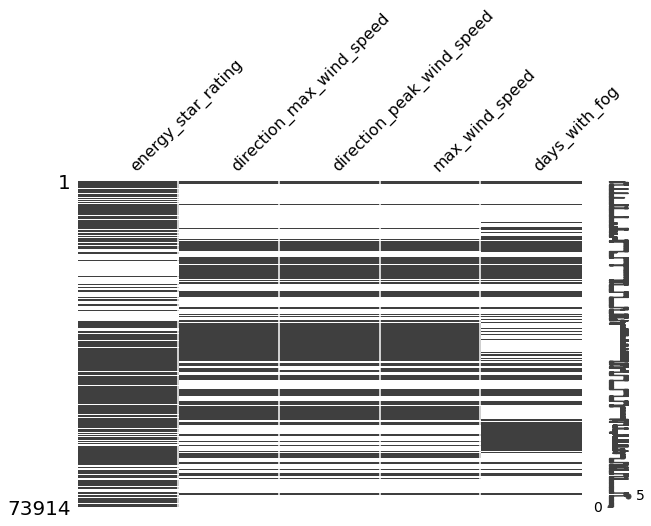

In [ ]:
#Visualizing missing values in columns
mno.matrix(train[null_cols],figsize= (10,6))
plt.show()

### Converting Year_Built into an Age Variable

In [ ]:
#Function for converting Year_Built into an Age variable
def age(df):
  if type(df['year_built']) == float and pd.isna(df['year_built']):
    return 0
  else:
    return (2022-df['year_built'])

In [ ]:
train['age'] = train.apply(age,axis = 1) # applies the function 'age' to train dataset. axis = 1 uses column name, axis = 0 uses index
train.drop('year_built', axis = 1, inplace = True) #drops 'year_built' column

In [ ]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,age
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,11.0,2.4,36,50.5,68,...,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,80.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,45.0,1.8,36,50.5,68,...,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,67.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,97.0,1.8,36,50.5,68,...,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,71.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,46.0,1.8,36,50.5,68,...,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,42.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,100.0,2.4,36,50.5,68,...,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,37.0


In [ ]:
train.shape

(73914, 64)

### Dropping ID column

In [ ]:
train.drop('id', axis = 1, inplace = True)

In [ ]:
train.shape

(73914, 63)

### Checking For Duplicate Entries

In [ ]:
print(f"Total number of Duplicate entries: {train.duplicated().sum()}")

Total number of Duplicate entries: 19


In [ ]:
train.drop_duplicates(inplace= True) #Removes dublicates

In [ ]:
#pd.set_option('display.max_rows', None) #ensures all rows are displayed

# nunique() counts the number of unique values in every column
# dropna = True ignores all NaNs
# .sort_values() sorr the values in ascending order
print(train.nunique(dropna = True).sort_values())

days_above_110F           1
building_class            2
days_above_100F           5
Year_Factor               6
State_Factor              7
                      ...  
ELEVATION                66
energy_star_rating      101
age                     179
floor_area            19591
site_eui              59737
Length: 63, dtype: int64


In [ ]:
#Creating a DataFrame with only columns with null values
train_null_cols = train[null_cols] #uses the list in null_cols to select the columns with NaN from the train dataset
train_null_cols.tail()

,energy_star_rating,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
75752,8.0,NaN,NaN,NaN,NaN
75753,98.0,NaN,NaN,NaN,NaN
75754,NaN,NaN,NaN,NaN,NaN
75755,NaN,NaN,NaN,NaN,NaN
75756,51.0,NaN,NaN,NaN,NaN


_____
### Visual Data Exploration

In [ ]:
#Making separate DataFrame for categorical and numerical features
# .select_dtypes(): 'object' = categorical data only, 'number' = numeric data only
train_cat = train.select_dtypes('object')
train_num = train.select_dtypes('number')

In [ ]:
print(train_num.head())
print(train_cat.head())

   floor_area  energy_star_rating  ELEVATION  january_min_temp  \
0     61242.0                11.0        2.4                36   
1    274000.0                45.0        1.8                36   
2    280025.0                97.0        1.8                36   
3     55325.0                46.0        1.8                36   
4     66000.0               100.0        2.4                36   

   january_avg_temp  january_max_temp  february_min_temp  february_avg_temp  \
0              50.5                68                 35          50.589286   
1              50.5                68                 35          50.589286   
2              50.5                68                 35          50.589286   
3              50.5                68                 35          50.589286   
4              50.5                68                 35          50.589286   

   february_max_temp  march_min_temp  ...  days_above_80F  days_above_90F  \
0                 73              40  ...          

### 2- Univariate Analysis of Categorical Variables

In [ ]:
train[train['facility_type'] == 'Education_College_or_university'] #selects only those with 'facility_type' meeting that type

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age
29,1,State_1,Commercial,Education_College_or_university,99522.0,NaN,59.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,24.792525,110.0
32,1,State_1,Commercial,Education_College_or_university,115000.0,NaN,59.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,35.090731,102.0
182,1,State_1,Commercial,Education_College_or_university,147509.0,NaN,18.6,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,62.169014,115.0
192,1,State_1,Commercial,Education_College_or_university,114053.0,81.0,18.6,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,68.273841,54.0
204,1,State_1,Commercial,Education_College_or_university,190066.0,NaN,18.6,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,108.696187,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74802,6,State_11,Commercial,Education_College_or_university,58779.0,NaN,26.5,26,36.612903,48,...,6,0,0,0,NaN,NaN,NaN,NaN,63.104294,53.0
74803,6,State_11,Commercial,Education_College_or_university,203030.0,NaN,26.5,26,36.612903,48,...,6,0,0,0,NaN,NaN,NaN,NaN,140.558550,24.0
74808,6,State_11,Commercial,Education_College_or_university,68072.0,NaN,26.5,26,36.612903,48,...,6,0,0,0,NaN,NaN,NaN,NaN,46.601514,60.0
75164,6,State_11,Commercial,Education_College_or_university,582447.0,NaN,18.3,28,43.451613,56,...,25,3,0,0,NaN,NaN,NaN,NaN,61.455865,52.0


In [ ]:
train[train['facility_type']== 'Warehouse_Nonrefrigerated']

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,100.0,2.4,36,50.500000,68,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,37.0
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,56.0,2.4,36,50.500000,68,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,40.0
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,99.0,2.4,36,50.500000,68,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,75.0
12,1,State_1,Commercial,Warehouse_Nonrefrigerated,128320.0,29.0,2.4,36,50.500000,68,...,14,0,0,0,1.0,1.0,1.0,NaN,79.300000,62.0
27,1,State_1,Commercial,Warehouse_Nonrefrigerated,195487.0,100.0,59.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,3.900000,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69321,6,State_8,Commercial,Warehouse_Nonrefrigerated,50000.0,69.0,32.0,8,29.827586,62,...,101,21,0,0,1.0,1.0,1.0,NaN,37.874764,53.0
69323,6,State_8,Commercial,Warehouse_Nonrefrigerated,66600.0,NaN,32.0,8,29.827586,62,...,101,21,0,0,1.0,1.0,1.0,NaN,15.965384,26.0
69324,6,State_8,Commercial,Warehouse_Nonrefrigerated,130500.0,88.0,32.0,8,29.827586,62,...,101,21,0,0,1.0,1.0,1.0,NaN,18.268438,68.0
69329,6,State_8,Commercial,Warehouse_Nonrefrigerated,77500.0,70.0,32.0,8,29.827586,62,...,101,21,0,0,1.0,1.0,1.0,NaN,18.112493,38.0


In [ ]:
train[train['floor_area'] > 4_000_000]

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age
6931,4,State_2,Commercial,Education_College_or_university,5634890.0,NaN,100.6,3,28.290323,59,...,93,17,0,0,NaN,NaN,NaN,NaN,257.615763,233.0
8411,5,State_2,Commercial,Education_College_or_university,5634890.0,NaN,3.0,8,29.966667,49,...,113,22,0,0,NaN,NaN,NaN,NaN,142.666065,233.0
9122,6,State_2,Commercial,Industrial,4101020.0,90.0,56.1,11,32.000000,62,...,109,38,0,0,NaN,NaN,NaN,NaN,137.822967,85.0
9907,6,State_2,Commercial,Education_College_or_university,5634890.0,NaN,3.0,11,32.000000,62,...,109,38,0,0,NaN,NaN,NaN,NaN,138.598997,233.0
10522,4,State_4,Commercial,Public_Safety_Penitentiary,4570176.0,NaN,217.9,-16,15.677419,45,...,67,1,0,0,NaN,NaN,NaN,37.0,163.308230,96.0
10608,4,State_4,Commercial,Office_Uncategorized,4483315.0,36.0,205.7,-16,15.677419,45,...,67,1,0,0,NaN,NaN,NaN,311.0,110.426654,49.0
10670,4,State_4,Commercial,Office_Uncategorized,4131093.0,NaN,210.3,-16,15.677419,45,...,67,1,0,0,NaN,NaN,NaN,NaN,66.406483,92.0
11077,5,State_4,Commercial,Public_Safety_Penitentiary,4570176.0,NaN,165.5,-8,21.935484,46,...,64,8,0,0,NaN,NaN,NaN,NaN,140.592373,96.0
11385,5,State_4,Commercial,Office_Uncategorized,4483315.0,55.0,189.0,-8,21.935484,46,...,64,8,0,0,NaN,NaN,NaN,106.0,86.782269,49.0
11542,5,State_4,Commercial,Office_Uncategorized,4131093.0,NaN,217.9,-8,21.935484,46,...,64,8,0,0,NaN,NaN,NaN,NaN,61.842946,92.0


In [ ]:
# printing the column names of facility types in the train DataFrame
print(train['facility_type'].unique())

['Grocery_store_or_food_market'
 'Warehouse_Distribution_or_Shipping_center' 'Retail_Enclosed_mall'
 'Education_Other_classroom' 'Warehouse_Nonrefrigerated'
 'Warehouse_Selfstorage' 'Office_Uncategorized' 'Data_Center'
 'Commercial_Other' 'Mixed_Use_Predominantly_Commercial'
 'Office_Medical_non_diagnostic' 'Education_College_or_university'
 'Industrial' 'Public_Assembly_Entertainment_culture'
 'Retail_Vehicle_dealership_showroom' 'Retail_Uncategorized'
 'Lodging_Hotel' 'Retail_Strip_shopping_mall' 'Education_Uncategorized'
 'Public_Assembly_Drama_theater' 'Public_Assembly_Social_meeting'
 'Religious_worship' 'Mixed_Use_Commercial_and_Residential'
 'Office_Bank_or_other_financial' 'Parking_Garage' 'Commercial_Unknown'
 'Service_Vehicle_service_repair_shop' 'Service_Drycleaning_or_Laundry'
 'Public_Assembly_Recreation' 'Service_Uncategorized'
 'Warehouse_Refrigerated' 'Food_Service_Uncategorized'
 'Health_Care_Uncategorized' 'Food_Service_Other'
 'Public_Assembly_Movie_Theater' 'Food_Se

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


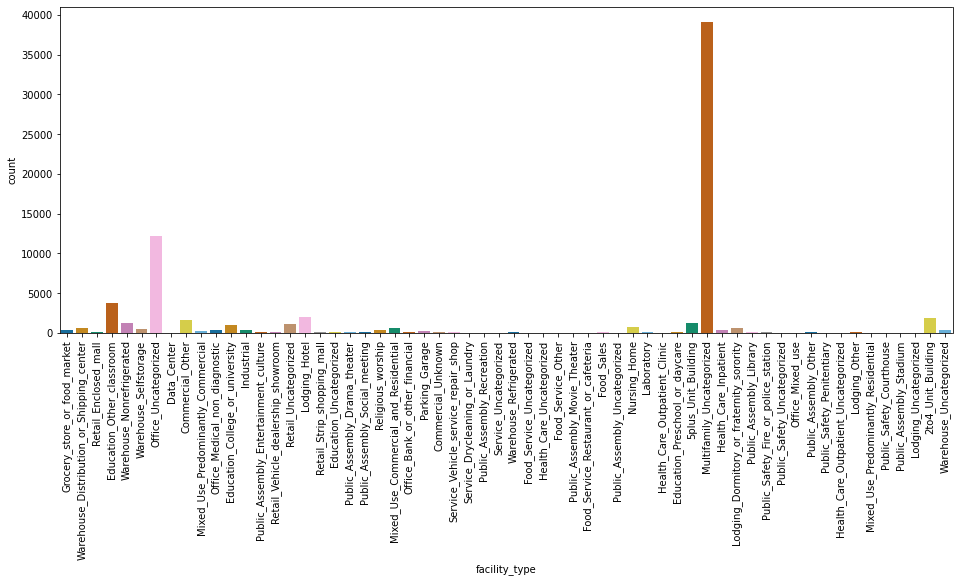

In [ ]:
# Plotting the updated facility types
plt.figure(figsize= (16,6))
sns.countplot(train['facility_type'], palette= "colorblind")
plt.xticks(rotation= 'vertical')
plt.show()

In [ ]:
print(train['facility_type'].nunique())

60


In [ ]:
# I am using str.contains to mask the rows that contain a specific string and then overwrite with the new value:
train.loc[train['facility_type'].str.contains('Lodging'), 'facility_type'] = 'lodging'
train.loc[train['facility_type'].str.contains('Education'), 'facility_type'] = 'education'
train.loc[train['facility_type'].str.contains('Health'), 'facility_type'] = 'healthcare'
train.loc[train['facility_type'].str.contains('Public_Safety'), 'facility_type'] = 'public_safety'
train.loc[train['facility_type'].str.contains('Public_Assembly'), 'facility_type'] = 'public_assembly'
train.loc[train['facility_type'].str.contains('Food', case = False), 'facility_type'] = 'food'
train.loc[train['facility_type'].str.contains('Retail'), 'facility_type'] = 'retail'
train.loc[train['facility_type'].str.contains('Warehouse'), 'facility_type'] = 'warehouse'
train.loc[train['facility_type'].str.contains('Service'), 'facility_type'] = 'service'
train.loc[train['facility_type'].str.contains('Commercial'), 'facility_type'] = 'commercial'
train.loc[train['facility_type'].str.contains('Office'), 'facility_type'] = 'office'
train.loc[train['facility_type'].str.contains('Residential'), 'facility_type'] = 'Multifamily_Uncategorized'
train.loc[train['facility_type'].str.contains('Building'), 'facility_type'] = 'Multifamily_Uncategorized'
train.loc[train['facility_type'].str.contains('Lab'), 'facility_type'] = 'healthcare'
train.loc[train['facility_type'].str.contains('Multifamily'), 'facility_type'] = 'Multifamily'
train.loc[train['facility_type'].str.contains('Data'), 'facility_type'] = 'commercial'
train.loc[train['facility_type'].str.contains('service'), 'facility_type'] = 'commercial'
train.loc[train['facility_type'].str.contains('Parking'), 'facility_type'] = 'commercial'

In [ ]:
print(train['facility_type'].nunique())

14


In [ ]:
print(train['facility_type'].unique())

['food' 'warehouse' 'retail' 'education' 'office' 'commercial'
 'Industrial' 'public_assembly' 'lodging' 'Religious_worship' 'healthcare'
 'Nursing_Home' 'Multifamily' 'public_safety']


In [ ]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count.index, norm_count, order = norm_count.index)
    plt.ylabel('fraction/percent', fontsize = 20)
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.xticks(rotation="vertical")
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


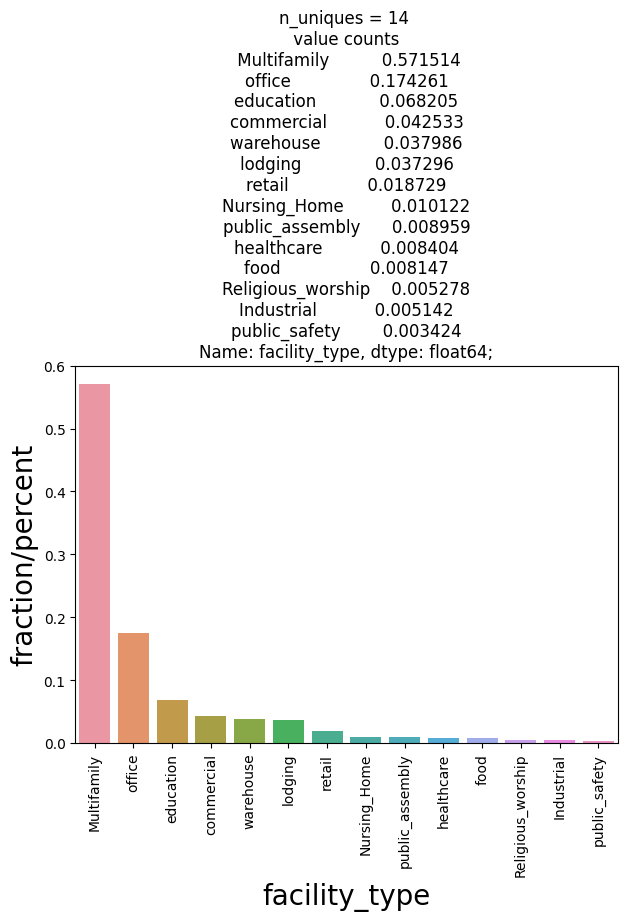

In [ ]:
UVA_category(train, ['facility_type'])

In [ ]:
train['facility_type'].value_counts(normalize = True)

Multifamily          0.571514
office               0.174261
education            0.068205
commercial           0.042533
warehouse            0.037986
lodging              0.037296
retail               0.018729
Nursing_Home         0.010122
public_assembly      0.008959
healthcare           0.008404
food                 0.008147
Religious_worship    0.005278
Industrial           0.005142
public_safety        0.003424
Name: facility_type, dtype: float64

In [ ]:
train.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age
0,1,State_1,Commercial,food,61242.0,11.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,80.0
1,1,State_1,Commercial,warehouse,274000.0,45.0,1.8,36,50.5,68,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,67.0
2,1,State_1,Commercial,retail,280025.0,97.0,1.8,36,50.5,68,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,71.0
3,1,State_1,Commercial,education,55325.0,46.0,1.8,36,50.5,68,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,42.0
4,1,State_1,Commercial,warehouse,66000.0,100.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,37.0
5,1,State_1,Commercial,warehouse,119900.0,NaN,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,66.0
6,1,State_1,Commercial,warehouse,91367.0,56.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,40.0
7,1,State_1,Commercial,warehouse,50422.0,99.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,75.0
8,1,State_1,Commercial,office,122020.0,98.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,93.0
9,1,State_1,Commercial,office,102612.0,83.0,2.4,36,50.5,68,...,14,0,0,0,1.0,1.0,1.0,NaN,29.515952,43.0


In [ ]:
train.loc[train['building_class'].str.contains('Commercial') & train['facility_type'].str.contains('education')]

,Year_Factor,State_Factor,building_class,facility_type,floor_area,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,age
3,1,State_1,Commercial,education,55325.0,46.0,1.8,36,50.500000,68,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,42.0
29,1,State_1,Commercial,education,99522.0,NaN,59.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,24.792525,110.0
32,1,State_1,Commercial,education,115000.0,NaN,59.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,35.090731,102.0
66,1,State_1,Commercial,education,71874.0,NaN,120.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,23.291454,115.0
107,1,State_1,Commercial,education,127074.0,NaN,120.1,36,50.500000,68,...,14,0,0,0,NaN,NaN,NaN,NaN,124.833648,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75617,6,State_11,Commercial,education,48925.0,82.0,313.0,28,43.451613,56,...,25,3,0,0,NaN,NaN,NaN,NaN,33.252716,8.0
75624,6,State_11,Commercial,education,131013.0,88.0,63.1,28,43.451613,56,...,25,3,0,0,NaN,NaN,NaN,NaN,29.646038,59.0
75625,6,State_11,Commercial,education,245587.0,92.0,63.1,28,43.451613,56,...,25,3,0,0,NaN,NaN,NaN,NaN,47.778162,63.0
75715,6,State_11,Commercial,education,23222.0,62.0,63.1,28,43.451613,56,...,25,3,0,0,NaN,NaN,NaN,NaN,52.387334,84.0


### Bivariate Analysis: Continuous & Categorical (Hypothesis Testing)

In [ ]:
from statsmodels.stats import weightstats as stests

In [ ]:
ztest, probability_value = stests.ztest(train["floor_area"], x2=train['site_eui'], value=train['floor_area'].mean()-train['site_eui'].mean())

In [ ]:
ztest, probability_value = 

In [ ]:
ztest, probability_value = stests.ztest(train["floor_area"], x2=train['site_eui'], value=train['floor_area'].mean()-train['site_eui'].mean())

In [ ]:
print((probability_value))

1.0
